# Follow up 10/01 meeting
## For deployment prep: 
compare seg2_glm to agg_rf to fallback for all tld-reseller combinations

so, for each domain, generate predictions based on 2 models & fallback tables

model predictions already exist, so just fallback tables & pull up the others for comparison

In [2]:
options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)

In [3]:
# install.packages("pkgcond")

In [4]:
library(dplyr)
library(data.table)
library(partykit)
library(tictoc)
library(caret)
library(e1071)
library(randomForest)
library(ranger)

#for 3d plotting
library(akima)
library(plotly)

# for prep data
library(rPython)
library(stringr)
library(pbapply)
library(stringdist)
library(data.table)
library(dominanceanalysis)


getwd()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm

Loading required package: lattice

Loading required package: ggplot2

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘ranger’


The following object is masked from ‘package:randomForest’:

    importance



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:sta

[1] "/home/jupyter/local/Domains_202003/scripts/phaseII_06"

In [5]:

source('../orig/functions.R')

source('../orig/functions_models.R')

source('../phaseII_03_forest/functions_eval.R')


source('../phaseII_03_forest/load_prep_data_expiry.R')

# expiry_train_prepped_2_1 (list, less df's w/ 0 obs)
# expiry_test_prepped_2_1  (list, less df's w/ 0 obs)
# expiry_train_df_1 (above, rbound)
# expiry_test_df_1 (above, rbound)
# expiry_train_df_sub (subset vars)                                        
# expiry_test_df_sub (subset vars)

## Load model predctions

In [6]:
predictions_df <- read.csv("../../data/tld_reseller_compare_predictions.csv")

dim(predictions_df)
head(predictions_df)

[1] 297100     12

,actual,pred_df_seg2_glm,pred_df_seg_glm,pred_df_agg_glm,pred_df_seg2_rf,pred_df_seg_rf,pred_df_agg_rf,tld_registrar_index,reseller,n,domain_id,domain
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<int>,<int>,<fct>
1,Not Renewd,0.6470992,0.558,0.419,0.4765771,0.4545657,0.5386137,sitegmo,gmo,106569,44295183,kagen.site
2,Renewed,0.6762222,0.567,0.397,0.5410605,0.5769973,0.6091513,sitegmo,gmo,106569,44573611,designlab.site
3,Renewed,0.9098495,0.835,0.410,0.7018108,0.6343404,0.6886680,sitegmo,gmo,106569,45304858,hokatu-blog.site
4,Renewed,0.6029350,0.515,0.402,0.2414726,0.3999603,0.3464197,sitegmo,gmo,106569,46235129,suzuya.site
5,Not Renewd,0.9311321,0.863,0.417,0.7749462,0.7039504,0.6711740,sitegmo,gmo,106569,46276970,wins-company.site
6,Renewed,0.9347869,0.861,0.391,0.6376848,0.6566740,0.6717237,sitegmo,gmo,106569,47809960,yamatoku-company.site


## Generate fallback predictions

In [7]:
npv_fallback_tables <- load("/home/jupyter/local/Domains_202003/data/npv_fallback_tables")
npv_fallback_tables

[1] "npv_fallback_first_final"        "npv_fallback_first_geo_arpt"    
 [3] "npv_fallback_first_geo_arpt_tld" "npv_fallback_first_tld_arpt"    
 [5] "npv_fallback_second_final"       "npv_fallback_second_geo"        
 [7] "npv_fallback_second_tld_geo"     "npv_fallback_third_final"       
 [9] "npv_fallback_third_geo"          "npv_fallback_third_tld_geo"

In [8]:
head(npv_fallback_first_final)

region,reg_arpt_slab,expiring_domains,renewed_domains,renewal_rate,index
<chr>,<fct>,<int>,<int>,<dbl>,<chr>
China,"(-Inf,0]",35669,2139,0.060,"China(-Inf,0]"
China,"(0,1]",536645,11052,0.021,"China(0,1]"
China,"(1,3]",84869,12063,0.142,"China(1,3]"
China,"(3,5]",1356,340,0.251,"China(3,5]"
China,"(5,10]",177,36,0.203,"China(5,10]"
China,"(10,15]",427,122,0.286,"China(10,15]"


In [9]:
head(npv_fallback_first_geo_arpt)

reseller_geo,reg_arpt_slab,expiring_domains,renewed_domains,renewal_rate,index
<chr>,<fct>,<int>,<int>,<dbl>,<chr>
Africa,"(0,1]",1278,34,0.027,"Africa(0,1]"
Africa,"(1,3]",1451,67,0.046,"Africa(1,3]"
Australia & New Zealand,"(1,3]",1087,276,0.254,"Australia & New Zealand(1,3]"
Australia & New Zealand,"(3,5]",773,264,0.342,"Australia & New Zealand(3,5]"
Australia & New Zealand,"(5,10]",2435,1129,0.464,"Australia & New Zealand(5,10]"
Australia & New Zealand,"(10,15]",713,308,0.432,"Australia & New Zealand(10,15]"


In [10]:
head(npv_fallback_first_geo_arpt_tld)

tld,reseller_geo,reg_arpt_slab,expiring_domains,renewed_domains,renewal_rate,index
<chr>,<chr>,<fct>,<int>,<int>,<dbl>,<chr>
fun,China,"(-Inf,0]",2098,111,0.053,"funChina(-Inf,0]"
fun,China,"(0,1]",82340,1910,0.023,"funChina(0,1]"
fun,China,"(1,3]",9991,1454,0.146,"funChina(1,3]"
fun,EU,"(-Inf,0]",901,8,0.009,"funEU(-Inf,0]"
fun,EU,"(0,1]",6206,210,0.034,"funEU(0,1]"
fun,EU,"(1,3]",1907,550,0.288,"funEU(1,3]"


## Using just npv_fallback_first_geo_arpt_tld to pull up renewal_rate given [tld,reseller_geo,reg_arpt] - **COnfirm w/ Parag**

In [11]:
dim(predictions_df)
head(predictions_df)

[1] 297100     12

,actual,pred_df_seg2_glm,pred_df_seg_glm,pred_df_agg_glm,pred_df_seg2_rf,pred_df_seg_rf,pred_df_agg_rf,tld_registrar_index,reseller,n,domain_id,domain
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<int>,<int>,<fct>
1,Not Renewd,0.6470992,0.558,0.419,0.4765771,0.4545657,0.5386137,sitegmo,gmo,106569,44295183,kagen.site
2,Renewed,0.6762222,0.567,0.397,0.5410605,0.5769973,0.6091513,sitegmo,gmo,106569,44573611,designlab.site
3,Renewed,0.9098495,0.835,0.410,0.7018108,0.6343404,0.6886680,sitegmo,gmo,106569,45304858,hokatu-blog.site
4,Renewed,0.6029350,0.515,0.402,0.2414726,0.3999603,0.3464197,sitegmo,gmo,106569,46235129,suzuya.site
5,Not Renewd,0.9311321,0.863,0.417,0.7749462,0.7039504,0.6711740,sitegmo,gmo,106569,46276970,wins-company.site
6,Renewed,0.9347869,0.861,0.391,0.6376848,0.6566740,0.6717237,sitegmo,gmo,106569,47809960,yamatoku-company.site


In [12]:
dim(expiry_test_df_1)
head(expiry_test_df_1)

[1] 296797     39

renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,reseller,reseller_country,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count
<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>
FirstTime,1,2020-01-22,91639803,segeln.fun,2019-01-22,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-22,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,segeln,l,6,6l,1,2.708050,2.23,segeln,1,1,1
FirstTime,1,2020-03-07,95819759,harzhotel.fun,2019-03-07,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-03-07,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,harzhotel,l,9,9l,1,2.708050,3.45,harzhotel,1,1,1
FirstTime,1,2020-01-15,91044973,movistar.fun,2019-01-15,Active,fun,10dencehispahard,10dencehispahard,Spain,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-01-15,10dencehispahard,10dencehispahard,15,15,1,15,15,15,fun10dencehispahard,movistar,l,8,8l,1,2.708050,8.62,movistar,1,1,1
FirstTime,1,2020-02-01,92472913,kuinik.fun,2019-02-01,Active,fun,10dencehispahard,10dencehispahard,Spain,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-02-01,10dencehispahard,10dencehispahard,15,15,1,15,15,15,fun10dencehispahard,kuinik,l,6,6l,1,2.708050,3.13,kuinik,1,1,1
FirstTime,1,2020-01-21,91532433,bulgari.fun,2019-01-21,Active,fun,1api,1api,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-21,1API,1API,5,5,1,15,15,5,fun1api,bulgari,l,7,7l,1,1.609438,4.51,bulgari,1,1,1
FirstTime,1,2020-04-24,101717674,gotsome.fun,2019-04-24,Active,fun,1api,1api,Germany,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-04-24,1API,1API,5,5,1,15,15,5,fun1api,gotsome,l,7,7l,1,1.609438,6.09,gotsome,1,1,1


In [13]:
# OUTER MERGE
test_predictions_df <- merge(expiry_test_df_1, 
                             predictions_df %>% select(pred_df_seg2_glm,pred_df_seg_glm,pred_df_agg_glm,pred_df_seg2_rf,
                                                       pred_df_seg_rf,pred_df_agg_rf,domain_id),
                            by="domain_id",
                            all=TRUE)
dim(test_predictions_df)
head(test_predictions_df)

[1] 297188     45

domain_id,renewal_type,renewed_count,expiry_date,domain,creation_date,status,tld,registrar,reseller,reseller_country,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,pred_df_seg2_glm,pred_df_seg_glm,pred_df_agg_glm,pred_df_seg2_rf,pred_df_seg_rf,pred_df_agg_rf
<int>,<chr>,<int>,<date>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [14]:
tail(test_predictions_df)

domain_id,renewal_type,renewed_count,expiry_date,domain,creation_date,status,tld,registrar,reseller,reseller_country,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,pred_df_seg2_glm,pred_df_seg_glm,pred_df_agg_glm,pred_df_seg2_rf,pred_df_seg_rf,pred_df_agg_rf
<int>,<chr>,<int>,<date>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
105791731,FirstTime,1,2020-05-31,male-masturbator.website,2019-05-31,Active,website,namecheap,namecheap,United States,Non China,1,NA,Not Renewd,0,auto-renewal,NA,2020-05-31,Namecheap,Namecheap,0.69,0.69,1,7.0,7.0,0.69,websitenamecheap,male-masturbator,hyphen-l,16,16hyphen-l,32,-0.3710637,7.22,2,male-mastrbator,0.0029296875,3,0.035552618,0.060,0.090,0.1056837,0.06770052,0.05148795
105791781,FirstTime,1,2020-05-31,miscellaneous-sex.website,2019-05-31,Active,website,namecheap,namecheap,United States,Non China,1,NA,Not Renewd,0,auto-renewal,NA,2020-05-31,Namecheap,Namecheap,0.69,0.69,1,7.0,7.0,0.69,websitenamecheap,miscellaneous-sex,hyphen-l,17,17hyphen-l,32,-0.3710637,6.48,4,miscellaneous-o,0.0019531250,2,0.043207768,0.063,0.098,0.1529932,0.12088394,0.09244550
105791786,FirstTime,1,2020-05-31,miscellaneous-toy.website,2019-05-31,Active,website,namecheap,namecheap,United States,Non China,1,NA,Not Renewd,0,auto-renewal,NA,2020-05-31,Namecheap,Namecheap,0.69,0.69,1,7.0,7.0,0.69,websitenamecheap,miscellaneous-toy,hyphen-l,17,17hyphen-l,32,-0.3710637,6.24,4,miscellaneous-o,0.0019531250,2,0.043158391,0.063,0.097,0.1568086,0.12168779,0.08792135
105791806,FirstTime,1,2020-05-31,penis-pump.website,2019-05-31,Active,website,namecheap,namecheap,United States,Non China,1,NA,Not Renewd,0,auto-renewal,NA,2020-05-31,Namecheap,Namecheap,0.69,0.69,1,7.0,7.0,0.69,websitenamecheap,penis-pump,hyphen-l,10,10hyphen-l,32,-0.3710637,5.91,13,penis-pump,0.0009765625,1,0.059277726,0.078,0.123,0.1467560,0.12874627,0.11966209
105791851,FirstTime,1,2020-05-31,pleasure-ball.website,2019-05-31,Active,website,namecheap,namecheap,United States,Non China,1,NA,Not Renewd,0,auto-renewal,NA,2020-05-31,Namecheap,Namecheap,0.69,0.69,1,7.0,7.0,0.69,websitenamecheap,pleasure-ball,hyphen-l,13,13hyphen-l,32,-0.3710637,6.75,14,pleasure-ball,0.0009765625,1,0.056854229,0.074,0.117,0.1578006,0.15714835,0.11602070
105791871,FirstTime,1,2020-05-31,6d838.fun,2019-05-31,Active,fun,pdr ltd,pdr ltd,India,Non China,1,NA,Not Renewd,0,auto-renewal,NA,2020-05-31,PDR Ltd,PDR Ltd,0.60,0.60,1,8.5,8.5,0.60,funpdr ltd,6d838,ln,5,5ln,9,-0.5108256,100.00,7,6d838,0.0123456790,1,0.003969189,0.062,0.093,0.0605583,0.07520340,0.07488694


In [15]:
# ... CREATES 391 ROWS WITH ALL NA'S
# test_predictions_df %>%
#   select(everything()) %>%  # replace to your needs
#   summarise_all(funs(sum(is.na(.)))) %>%   t()
test_predictions_df %>% is.na %>% colSums

domain_id         renewal_type        renewed_count 
                 391                  391                  391 
         expiry_date               domain        creation_date 
                 391                  391                  391 
              status                  tld            registrar 
                 391                  391                  391 
            reseller     reseller_country               region 
                 391                  391                  391 
          reg_period   registrant_country       renewal_status 
                 391               297084                  391 
           renew_mbg           renew_type       autorenew_type 
                 391                 8524                72641 
          renew_date      renew_registrar       renew_reseller 
                8531                  391                  391 
         reg_revenue             reg_arpt         renew_period 
                 391                  391                 8531 
renew_domain_revenue           renew_arpt         reg_arpt_org 
                 391                 8531                  391 
 tld_registrar_index                  sld             sld_type 
                 391                  391                  391 
          sld_length            sld_type2          day_domains 
                 391                  391                  391 
        log_reg_arpt           gibb_score              pattern 
                 391                  391                  391 
             cluster        pattern_score pattern_domain_count 
                 391                  391                  391 
    pred_df_seg2_glm      pred_df_seg_glm      pred_df_agg_glm 
                1745                  575                  479 
     pred_df_seg2_rf       pred_df_seg_rf       pred_df_agg_rf 
                 479                  479                  479

In [16]:
#... which, subtracted from nrows, gives the initial dim of predictions_df
297188-391

[1] 296797

In [17]:
#... so just do left merge
test_predictions_df <- merge(expiry_test_df_1, 
                             predictions_df %>% select(pred_df_seg2_glm,pred_df_seg_glm,pred_df_agg_glm,pred_df_seg2_rf,
                                                       pred_df_seg_rf,pred_df_agg_rf,domain_id),
                            by="domain_id",
                            all.x=TRUE)
dim(test_predictions_df)
head(test_predictions_df)

[1] 296797     45

domain_id,renewal_type,renewed_count,expiry_date,domain,creation_date,status,tld,registrar,reseller,reseller_country,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,pred_df_seg2_glm,pred_df_seg_glm,pred_df_agg_glm,pred_df_seg2_rf,pred_df_seg_rf,pred_df_agg_rf
<int>,<chr>,<int>,<date>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1018925,FirstTime,1,2020-01-16,eth.pw,2016-01-16,Active,pw,name.com,name.com,United States,Non China,4,United States,Renewed,0,renewal,NULL,2015-02-27,Name.com,Name.com,24.0,6.00,1,6.0,6.0,6.00,pwname.com,eth,l,3,3l,1,1.791759,8.89,eth,1,1,1,0.99999903,0.322,0.484,0.7404987,0.5118349,0.4434424
1837805,FirstTime,1,2020-02-04,kitetsumemo.in.net,2014-02-04,Active,in.net,gmo,gmo,Japan,Non China,6,Japan,Renewed,0,renewal,NULL,2020-01-19,GMO,GMO,32.0,5.33,1,6.0,6.0,5.33,in.netgmo,kitetsumemo,l,11,11l,1,1.673351,6.30,kitetsumemo,1,1,1,1.00000000,0.940,0.724,0.7803139,0.6546858,0.4043908
2294288,FirstTime,1,2020-03-31,issei.pw,2014-03-31,Active,pw,gmo,gmo,Japan,Non China,6,Japan,Not Renewd,0,auto-renewal,NULL,2020-03-31,GMO,GMO,33.0,5.50,1,15.0,15.0,5.50,pwgmo,issei,l,5,5l,1,1.704748,5.66,issei,1,1,1,0.80186273,0.770,0.601,0.6163054,0.4580625,0.3594618
6752374,FirstTime,1,2020-01-04,netbarg.website,2015-01-04,Active,website,namecheap,namecheap,United States,Non China,5,Germany,Renewed,0,renewal,NULL,2019-12-05,Namecheap,Namecheap,17.5,3.50,1,7.5,7.5,3.50,websitenamecheap,netbarg,l,7,7l,1,1.252763,1.94,netbarg,1,1,1,0.37871416,0.719,0.482,0.5009564,0.4438893,0.3763672
6758279,FirstTime,1,2020-01-06,flyspringfield.website,2015-01-06,Active,website,enom,enom,United States,Non China,5,United States,Renewed,0,renewal,NULL,2020-01-02,eNom,eNom,50.0,10.00,3,45.0,15.0,10.00,websiteenom,flyspringfield,l,14,14l,1,2.302585,4.44,flyspringfield,1,1,1,0.07396782,0.362,0.758,0.2022334,0.3703322,0.3475753
6758512,FirstTime,1,2020-01-06,bosslife.website,2015-01-06,Active,website,network solutions,network solutions,United States,Non China,5,United States,Renewed,0,renewal,NULL,2019-11-07,Network Solutions,Network Solutions,75.0,15.00,5,75.0,15.0,15.00,websitenetwork solutions,bosslife,l,8,8l,1,2.708050,4.59,bosslife,1,1,1,1.00000000,0.943,0.829,0.8070811,0.8096157,0.6575082


In [18]:
names(test_predictions_df)

[1] "domain_id"            "renewal_type"         "renewed_count"       
 [4] "expiry_date"          "domain"               "creation_date"       
 [7] "status"               "tld"                  "registrar"           
[10] "reseller"             "reseller_country"     "region"              
[13] "reg_period"           "registrant_country"   "renewal_status"      
[16] "renew_mbg"            "renew_type"           "autorenew_type"      
[19] "renew_date"           "renew_registrar"      "renew_reseller"      
[22] "reg_revenue"          "reg_arpt"             "renew_period"        
[25] "renew_domain_revenue" "renew_arpt"           "reg_arpt_org"        
[28] "tld_registrar_index"  "sld"                  "sld_type"            
[31] "sld_length"           "sld_type2"            "day_domains"         
[34] "log_reg_arpt"         "gibb_score"           "pattern"             
[37] "cluster"              "pattern_score"        "pattern_domain_count"
[40] "pred_df_seg2_glm"     "pred_df_seg_glm"      "pred_df_agg_glm"     
[43] "pred_df_seg2_rf"      "pred_df_seg_rf"       "pred_df_agg_rf"

### create reseller_geo and reg_arpt_slab variables to (along with tld) merge with npv_fallback_first_geo_arpt_tld

#### reseller_geo

In [19]:
anomalyDF <- read.csv("/home/jupyter/local/Domains_202003/data/PredictiveModelAnalysis_AnomalyRegistrars.csv")
anomalyDF <- apply(anomalyDF, 2, function(x) trimws(x,which = c("both")) )
geoLookupDF <- unique(anomalyDF[,c('reseller','reseller_country','reseller_geo')])
geoLookupDF <- as.data.frame(geoLookupDF)
head(geoLookupDF)

,reseller,reseller_country,reseller_geo
,<fct>,<fct>,<fct>
1,007names,United States,United States
2,0101 internet,Hong Kong,China
3,1&1 internet,Germany,EU
4,101 domain,United States,United States
5,101domain discovery,Germany,EU
6,10dencehispahard,Spain,EU


In [20]:
head(test_predictions_df[,c('reseller','reseller_country')])
head(geoLookupDF[,c('reseller','reseller_country')])

reseller,reseller_country
<chr>,<chr>
name.com,United States
gmo,Japan
gmo,Japan
namecheap,United States
enom,United States
network solutions,United States


,reseller,reseller_country
,<fct>,<fct>
1,007names,United States
2,0101 internet,Hong Kong
3,1&1 internet,Germany
4,101 domain,United States
5,101domain discovery,Germany
6,10dencehispahard,Spain


In [21]:
# ensure correct number of dimm
dim(test_predictions_df)
test_predictions_df_2 <- merge(as.data.frame(test_predictions_df),
                           geoLookupDF,
                           on=c('reseller','reseller_country'), 
                           all.x = TRUE)
dim(test_predictions_df_2)
head(test_predictions_df_2)


[1] 296797     45

[1] 296797     46

,reseller,reseller_country,domain_id,renewal_type,renewed_count,expiry_date,domain,creation_date,status,tld,registrar,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,pred_df_seg2_glm,pred_df_seg_glm,pred_df_agg_glm,pred_df_seg2_rf,pred_df_seg_rf,pred_df_agg_rf,reseller_geo
,<chr>,<chr>,<int>,<chr>,<int>,<date>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,1&1 internet,Germany,101703069,FirstTime,1,2020-04-24,yogaraum.online,2019-04-24,Active,online,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-04-24,1&1 Internet,1&1 Internet,0,0.0001,1,9,9,0,online1&1 internet,yogaraum,l,8,8l,13,-9.210340,3.73,2,yogaraum,0.005917160,1,0.4857198,0.491,0.403,0.6758974,0.6667279,0.6241976,EU
2,1&1 internet,Germany,91056433,FirstTime,1,2020-01-15,b2i.online,2019-01-15,Active,online,1&1 internet,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-01-15,1&1 Internet,1&1 Internet,5,5.0000,1,25,25,5,online1&1 internet,b2i,ln,3,3ln,25,1.609438,3.57,21,b2i,0.001600000,1,0.4943012,0.501,0.393,0.6151921,0.6019267,0.5908605,EU
3,1&1 internet,Germany,97680624,FirstTime,1,2020-03-23,get3d.online,2019-03-23,Active,online,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-03-23,1&1 Internet,1&1 Internet,0,0.0001,1,9,9,0,online1&1 internet,get3d,ln,5,5ln,6,-9.210340,0.63,6,get3d,0.027777778,1,0.4275131,0.432,0.269,0.4756694,0.4035293,0.4261295,EU
4,1&1 internet,Germany,60260863,FirstTime,1,2020-01-29,mob-it-alia.online,2018-01-29,Active,online,1&1 internet,Non China,2,NA,Renewed,0,auto-renewal,realized,2020-01-29,1&1 Internet,1&1 Internet,30,15.0000,1,25,25,15,online1&1 internet,mob-it-alia,hyphen-l,11,11hyphen-l,3,2.708050,4.76,1,mob-it-alia,0.111111111,1,0.6278206,0.620,0.670,0.6279631,0.5926415,0.5680841,EU
5,1&1 internet,Germany,102370019,FirstTime,1,2020-04-29,fusion-web.online,2019-04-29,Active,online,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-04-29,1&1 Internet,1&1 Internet,0,0.0001,1,25,25,0,online1&1 internet,fusion-web,hyphen-l,10,10hyphen-l,18,-9.210340,3.00,7,fusion-web,0.003086420,1,0.5592457,0.563,0.413,0.5777930,0.5547513,0.5591712,EU
6,1&1 internet,Germany,99438074,FirstTime,1,2020-04-09,eclipso.online,2019-04-09,Active,online,1&1 internet,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-04-09,1&1 Internet,1&1 Internet,0,0.0001,1,25,25,0,online1&1 internet,eclipso,l,7,7l,11,-9.210340,3.07,6,eclipso,0.008264463,1,0.4950218,0.501,0.406,0.5586089,0.5506126,0.5202133,EU


In [22]:
# dims match... replace original
test_predictions_df <- test_predictions_df_2

In [23]:
# NA reseller_gep
test_predictions_df %>% is.na %>% colSums

reseller     reseller_country            domain_id 
                   0                    0                    0 
        renewal_type        renewed_count          expiry_date 
                   0                    0                    0 
              domain        creation_date               status 
                   0                    0                    0 
                 tld            registrar               region 
                   0                    0                    0 
          reg_period   registrant_country       renewal_status 
                   0               296693                    0 
           renew_mbg           renew_type       autorenew_type 
                   0                 8133                72250 
          renew_date      renew_registrar       renew_reseller 
                8140                    0                    0 
         reg_revenue             reg_arpt         renew_period 
                   0                    0                 8140 
renew_domain_revenue           renew_arpt         reg_arpt_org 
                   0                 8140                    0 
 tld_registrar_index                  sld             sld_type 
                   0                    0                    0 
          sld_length            sld_type2          day_domains 
                   0                    0                    0 
        log_reg_arpt           gibb_score              pattern 
                   0                    0                    0 
             cluster        pattern_score pattern_domain_count 
                   0                    0                    0 
    pred_df_seg2_glm      pred_df_seg_glm      pred_df_agg_glm 
                1354                  184                   88 
     pred_df_seg2_rf       pred_df_seg_rf       pred_df_agg_rf 
                  88                   88                   88 
        reseller_geo 
                1149

In [24]:
# for parag: resellers with no reseller_geo
test_predictions_df %>% filter(is.na(reseller_geo)) %>% select(reseller,reseller_country) %>% unique()

,reseller,reseller_country
,<chr>,<chr>
1,amen fr,France
179,hostinger 2,Lithuania
180,innovadeus,
182,interserver,United States
199,key-systems,Netherlands
327,net4 india,
328,pdr ltd,United States
330,registrator domenov,Russia
385,shopify,United States


In [25]:
test_predictions_df %>% pull(reseller_geo) %>% unique()

[1] EU                         United States             
 [3] Australia & New Zealand    China                     
 [5] Turkey                     South Africa              
 [7] Others                     <NA>                      
 [9] Russia                     Vietnam, Korea & Indonesia
[11] India                      Latam                     
[13] Canada                     Japan                     
[15] Africa                    
15 Levels: Africa Australia & New Zealand Canada China EU India Japan ... Vietnam, Korea & Indonesia

#### reg_arpt_slab

In [26]:
npv_fallback_first_geo_arpt_tld %>% pull(reg_arpt_slab)  %>% unique()

[1] (-Inf,0]  (0,1]     (1,3]     (10,15]   (5,10]    (3,5]     (15,25]  
[8] (35, Inf] (25,35]  
9 Levels: (-Inf,0] (0,1] (1,3] (3,5] (5,10] (10,15] (15,25] ... (35, Inf]

In [27]:
test_predictions_df <- test_predictions_df %>% 
  mutate(reg_arpt_slab=cut(reg_arpt, breaks=c(-Inf, 0, 1, 3, 5, 10, 15, 25, 35, Inf)))
test_predictions_df %>% select (reg_arpt, reg_arpt_slab) %>% head(20)

,reg_arpt,reg_arpt_slab
,<dbl>,<fct>
1,0.0001,"(0,1]"
2,5.0000,"(3,5]"
3,0.0001,"(0,1]"
4,15.0000,"(10,15]"
5,0.0001,"(0,1]"
6,0.0001,"(0,1]"
7,15.0000,"(10,15]"
8,10.0000,"(5,10]"
9,0.0001,"(0,1]"


## Merge test_predictions_df with fallback table

In [28]:
head((npv_fallback_first_geo_arpt_tld))

tld,reseller_geo,reg_arpt_slab,expiring_domains,renewed_domains,renewal_rate,index
<chr>,<chr>,<fct>,<int>,<int>,<dbl>,<chr>
fun,China,"(-Inf,0]",2098,111,0.053,"funChina(-Inf,0]"
fun,China,"(0,1]",82340,1910,0.023,"funChina(0,1]"
fun,China,"(1,3]",9991,1454,0.146,"funChina(1,3]"
fun,EU,"(-Inf,0]",901,8,0.009,"funEU(-Inf,0]"
fun,EU,"(0,1]",6206,210,0.034,"funEU(0,1]"
fun,EU,"(1,3]",1907,550,0.288,"funEU(1,3]"


In [29]:
npv_fallback_first_geo_arpt_tld <- as.data.frame(npv_fallback_first_geo_arpt_tld)

In [30]:
head((npv_fallback_first_geo_arpt_tld))

,tld,reseller_geo,reg_arpt_slab,expiring_domains,renewed_domains,renewal_rate,index
,<chr>,<chr>,<fct>,<int>,<int>,<dbl>,<chr>
1,fun,China,"(-Inf,0]",2098,111,0.053,"funChina(-Inf,0]"
2,fun,China,"(0,1]",82340,1910,0.023,"funChina(0,1]"
3,fun,China,"(1,3]",9991,1454,0.146,"funChina(1,3]"
4,fun,EU,"(-Inf,0]",901,8,0.009,"funEU(-Inf,0]"
5,fun,EU,"(0,1]",6206,210,0.034,"funEU(0,1]"
6,fun,EU,"(1,3]",1907,550,0.288,"funEU(1,3]"


In [31]:
str(test_predictions_df[,c('tld', 'reseller_geo', 'reg_arpt_slab')])
str(npv_fallback_first_geo_arpt_tld[,c('tld', 'reseller_geo', 'reg_arpt_slab')])

'data.frame':	296797 obs. of  3 variables:
 $ tld          : Factor w/ 11 levels "fun","host","in.net",..: 4 4 4 4 4 4 4 9 4 4 ...
 $ reseller_geo : Factor w/ 15 levels "Africa","Australia & New Zealand",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ reg_arpt_slab: Factor w/ 9 levels "(-Inf,0]","(0,1]",..: 2 4 2 6 2 2 6 5 2 2 ...
'data.frame':	219 obs. of  3 variables:
 $ tld          : chr  "fun" "fun" "fun" "fun" ...
 $ reseller_geo : chr  "China" "China" "China" "EU" ...
 $ reg_arpt_slab: Factor w/ 9 levels "(-Inf,0]","(0,1]",..: 1 2 3 1 2 3 6 2 2 3 ...


In [32]:
npv_fallback_first_geo_arpt_tld$tld <- factor(npv_fallback_first_geo_arpt_tld$tld)
npv_fallback_first_geo_arpt_tld$reseller_geo <- factor(npv_fallback_first_geo_arpt_tld$reseller_geo)

In [33]:
str(test_predictions_df[,c('tld', 'reseller_geo', 'reg_arpt_slab')])
str(npv_fallback_first_geo_arpt_tld[,c('tld', 'reseller_geo', 'reg_arpt_slab')])

'data.frame':	296797 obs. of  3 variables:
 $ tld          : Factor w/ 11 levels "fun","host","in.net",..: 4 4 4 4 4 4 4 9 4 4 ...
 $ reseller_geo : Factor w/ 15 levels "Africa","Australia & New Zealand",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ reg_arpt_slab: Factor w/ 9 levels "(-Inf,0]","(0,1]",..: 2 4 2 6 2 2 6 5 2 2 ...
'data.frame':	219 obs. of  3 variables:
 $ tld          : Factor w/ 11 levels "fun","host","in.net",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ reseller_geo : Factor w/ 13 levels "Africa","Australia & New Zealand",..: 4 4 4 5 5 5 5 6 7 7 ...
 $ reg_arpt_slab: Factor w/ 9 levels "(-Inf,0]","(0,1]",..: 1 2 3 1 2 3 6 2 2 3 ...


In [34]:
test_predictions_fallback_df <- merge(test_predictions_df, 
                                      npv_fallback_first_geo_arpt_tld %>% select(tld,reseller_geo,reg_arpt_slab,renewal_rate),
      on = c('tld', 'reseller_geo', 'reg_arpt_slab'), 
      all.x = TRUE)
dim(test_predictions_df)
dim(test_predictions_fallback_df)
head(test_predictions_fallback_df)

[1] 296797     47

[1] 296797     48

,tld,reseller_geo,reg_arpt_slab,reseller,reseller_country,domain_id,renewal_type,renewed_count,expiry_date,domain,creation_date,status,registrar,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,pred_df_seg2_glm,pred_df_seg_glm,pred_df_agg_glm,pred_df_seg2_rf,pred_df_seg_rf,pred_df_agg_rf,renewal_rate
,<fct>,<fct>,<fct>,<chr>,<chr>,<int>,<chr>,<int>,<date>,<chr>,<date>,<chr>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,fun,Australia & New Zealand,"(3,5]",instra corporation,Australia,104893671,FirstTime,1,2020-05-25,laur.fun,2019-05-25,Active,instra corporation,Non China,1,NA,Not Renewd,0,auto-renewal,NA,2020-05-25,Instra Corporation,Instra Corporation,4,4,1,15,15,4,funinstra corporation,laur,l,4,4l,1,1.386294,5.48,laur,1,1,1,NA,0.000,0.151,0.00000,0.1851779,0.3718108,NA
2,fun,Australia & New Zealand,"(3,5]",instra corporation,Australia,99540944,FirstTime,1,2020-04-10,oferty.fun,2019-04-10,Active,instra corporation,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-04-10,Instra Corporation,Instra Corporation,4,4,1,15,15,4,funinstra corporation,oferty,l,6,6l,1,1.386294,6.03,oferty,1,1,1,NA,0.000,0.146,0.00000,0.2157494,0.3943426,NA
3,fun,Australia & New Zealand,"(5,10]",crazy domains,Australia,62376247,FirstTime,1,2020-03-07,tennisladder.fun,2018-03-07,Active,crazy domains,Non China,2,NA,Not Renewd,0,auto-renewal,unrealized,2020-03-07,Crazy Domains,Crazy Domains,18,9,1,15,15,9,funcrazy domains,tennisladder,l,12,12l,1,2.197225,4.85,tennisladder,1,1,1,1.0000000,0.400,0.334,0.42460,0.5788189,0.6221085,NA
4,fun,Australia & New Zealand,"(10,15]",ventraip,Australia,95252714,FirstTime,1,2020-03-03,letterific.fun,2019-03-03,Active,synergy wholesale,Non China,1,NA,Renewed,0,renewal,NA,2020-02-19,SYNERGY WHOLESALE,VentraIP,15,15,1,15,15,15,funventraip,letterific,l,10,10l,1,2.708050,5.97,letterific,1,1,1,NA,NA,NA,NA,NA,NA,NA
5,fun,Canada,"(5,10]",hover,Canada,104937931,FirstTime,1,2020-05-26,futurefantasy.fun,2019-05-26,Active,tucows,Non China,1,NA,Renewed,0,renewal,NA,2020-05-25,Tucows,Hover,8,8,1,15,15,8,funhover,futurefantasy,l,13,13l,1,2.079442,5.61,futurefantasy,1,1,1,0.6261119,0.624,0.267,0.59825,0.5677353,0.4933172,NA
6,fun,Canada,"(5,10]",hover,Canada,99187839,FirstTime,1,2020-04-08,flabocci.fun,2019-04-08,Active,tucows,Non China,1,NA,Renewed,0,renewal,NA,2020-04-07,Tucows,Hover,8,8,1,15,15,8,funhover,flabocci,l,8,8l,1,2.079442,3.66,flabocci,1,1,1,0.6175394,0.610,0.282,0.59825,0.6966527,0.5897817,NA


In [35]:
npv_fallback_first_geo_arpt_tld %>% filter( tld == 'fun')

tld,reseller_geo,reg_arpt_slab,expiring_domains,renewed_domains,renewal_rate,index
<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<chr>
fun,China,"(-Inf,0]",2098,111,0.053,"funChina(-Inf,0]"
fun,China,"(0,1]",82340,1910,0.023,"funChina(0,1]"
fun,China,"(1,3]",9991,1454,0.146,"funChina(1,3]"
fun,EU,"(-Inf,0]",901,8,0.009,"funEU(-Inf,0]"
fun,EU,"(0,1]",6206,210,0.034,"funEU(0,1]"
fun,EU,"(1,3]",1907,550,0.288,"funEU(1,3]"
fun,EU,"(10,15]",664,405,0.610,"funEU(10,15]"
fun,India,"(0,1]",1180,30,0.025,"funIndia(0,1]"
fun,Japan,"(0,1]",6931,1478,0.213,"funJapan(0,1]"


# Regenerate npv_fallback_first_geo_arpt_tld based on training data (?)

In [36]:
head(npv_fallback_first_geo_arpt_tld)

,tld,reseller_geo,reg_arpt_slab,expiring_domains,renewed_domains,renewal_rate,index
,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<chr>
1,fun,China,"(-Inf,0]",2098,111,0.053,"funChina(-Inf,0]"
2,fun,China,"(0,1]",82340,1910,0.023,"funChina(0,1]"
3,fun,China,"(1,3]",9991,1454,0.146,"funChina(1,3]"
4,fun,EU,"(-Inf,0]",901,8,0.009,"funEU(-Inf,0]"
5,fun,EU,"(0,1]",6206,210,0.034,"funEU(0,1]"
6,fun,EU,"(1,3]",1907,550,0.288,"funEU(1,3]"


In [37]:
head(expiry_train_df_1)

renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,reseller,reseller_country,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count
<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>
FirstTime,1,2020-01-21,91584433,racefor.fun,2019-01-21,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-21,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,racefor,l,7,7l,1,2.70805,6.77,racefor,1,1,1
FirstTime,1,2020-01-30,92254793,united4.fun,2019-01-30,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-30,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,united4,ln,7,7ln,1,2.70805,8.65,united4,1,1,1
FirstTime,1,2020-02-04,92827233,bereal.fun,2019-02-04,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-04,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,bereal,l,6,6l,1,2.70805,13.09,bereal,1,1,1
FirstTime,1,2020-02-12,93490823,dogsoutdoors.fun,2019-02-12,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-02-12,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,dogsoutdoors,l,12,12l,1,2.70805,2.44,dogsoutdoors,1,1,1
FirstTime,1,2020-02-15,93767978,rosalux.fun,2019-02-15,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-15,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,rosalux,l,7,7l,1,2.70805,2.34,rosalux,1,1,1
FirstTime,1,2020-02-16,93823708,verygood.fun,2019-02-16,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-16,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,verygood,l,8,8l,1,2.70805,3.64,verygood,1,1,1


In [38]:
# ensure correct number of dimm
dim(expiry_train_df_1)
npv_fallback_first_geo_arpt_tld_2 <- merge(as.data.frame(expiry_train_df_1),
                           geoLookupDF,
                           on=c('reseller','reseller_country'), 
                           all.x = TRUE)
dim(npv_fallback_first_geo_arpt_tld_2)
head(npv_fallback_first_geo_arpt_tld_2)


[1] 1188250      39

[1] 1188250      40

,reseller,reseller_country,renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,reseller_geo
,<chr>,<chr>,<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<fct>
1,1&1 internet,Germany,FirstTime,1,2020-05-10,103266019,partner-expert-frst-2626.online,2019-05-10,Deleted,online,1&1 internet,Non China,1,NA,Not Renewd,0,NA,NA,NA,Not Assigned,Not Assigned,0.0,1e-04,NA,0,NA,0.0,online1&1 internet,partner-expert-frst-2626,hyphen-ln,24,24hyphen-ln,50,-9.2103404,4.91,37,partner-expert-frst-2626,0.0004000000,1,EU
2,1&1 internet,Germany,FirstTime,1,2020-05-10,103260954,gonzalezabogada.online,2019-05-10,Active,online,1&1 internet,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-05-10,1&1 Internet,1&1 Internet,0.0,1e-04,1,25,25,0.0,online1&1 internet,gonzalezabogada,l,15,15l,50,-9.2103404,2.56,36,gonzalezabogada,0.0004000000,1,EU
3,1&1 internet,Germany,FirstTime,1,2020-04-05,99000139,jayliggins.online,2019-04-05,Active,online,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-04-05,1&1 Internet,1&1 Internet,0.0,1e-04,1,25,25,0.0,online1&1 internet,jayliggins,l,10,10l,68,-9.2103404,4.24,34,jayliggins,0.0002162630,1,EU
4,1&1 internet,Germany,FirstTime,1,2020-05-07,103007364,amalfitano.online,2019-05-07,Active,online,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-05-07,1&1 Internet,1&1 Internet,0.0,1e-04,1,25,25,0.0,online1&1 internet,amalfitano,l,10,10l,48,-9.2103404,6.79,3,amalfitano,0.0004340278,1,EU
5,1&1 internet,Germany,FirstTime,1,2020-04-07,99134414,pizza-palazzo.online,2019-04-07,Active,online,1&1 internet,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-04-07,1&1 Internet,1&1 Internet,0.8,8e-01,1,25,25,0.8,online1&1 internet,pizza-palazzo,hyphen-l,13,13hyphen-l,34,-0.2231436,3.33,2,pizza-palazzo,0.0008650519,1,EU
6,1&1 internet,Germany,FirstTime,1,2020-05-07,103003979,barleybear.online,2019-05-07,Active,online,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-05-07,1&1 Internet,1&1 Internet,1.0,1e+00,1,25,25,1.0,online1&1 internet,barleybear,l,10,10l,48,0.0000000,4.21,5,barleybear,0.0004340278,1,EU


In [39]:
npv_fallback_first_geo_arpt_tld_2 <- npv_fallback_first_geo_arpt_tld_2 %>% 
  mutate(reg_arpt_slab=cut(reg_arpt, breaks=c(-Inf, 0, 1, 3, 5, 10, 15, 25, 35, Inf)))
npv_fallback_first_geo_arpt_tld_2  %>% select (reg_arpt, reg_arpt_slab) %>% head(20)

,reg_arpt,reg_arpt_slab
,<dbl>,<fct>
1,1e-04,"(0,1]"
2,1e-04,"(0,1]"
3,1e-04,"(0,1]"
4,1e-04,"(0,1]"
5,8e-01,"(0,1]"
6,1e+00,"(0,1]"
7,1e-04,"(0,1]"
8,1e-04,"(0,1]"
9,1e+00,"(0,1]"


In [40]:
npv_fallback_first_geo_arpt_tld_2 = npv_fallback_first_geo_arpt_tld_2 %>%
  group_by(tld,reseller_geo,reg_arpt_slab) %>%
  summarise(expiring_domains = n(),
              renewed_domains=sum(renewal_status=='Renewed'),
              renewal_rate=renewed_domains/expiring_domains)

head(npv_fallback_first_geo_arpt_tld_2)

`summarise()` regrouping output by 'tld', 'reseller_geo' (override with `.groups` argument)



tld,reseller_geo,reg_arpt_slab,expiring_domains,renewed_domains,renewal_rate
<fct>,<fct>,<fct>,<int>,<int>,<dbl>
fun,Australia & New Zealand,"(3,5]",4,1,0.250000000
fun,Australia & New Zealand,"(5,10]",4,2,0.500000000
fun,Australia & New Zealand,"(10,15]",3,1,0.333333333
fun,Canada,"(5,10]",19,10,0.526315789
fun,Canada,"(10,15]",7,4,0.571428571
fun,China,"(0,1]",101332,983,0.009700786


## leverage regenrated fallback table

In [45]:
npv_fallback_first_geo_arpt_tld_2 <- as.data.frame(npv_fallback_first_geo_arpt_tld_2)

In [47]:
npv_fallback_first_geo_arpt_tld_2$tld <- factor(npv_fallback_first_geo_arpt_tld_2$tld)
npv_fallback_first_geo_arpt_tld_2$reseller_geo <- factor(npv_fallback_first_geo_arpt_tld_2$reseller_geo)

In [48]:
str(test_predictions_df[,c('tld', 'reseller_geo', 'reg_arpt_slab')])
str(npv_fallback_first_geo_arpt_tld_2[,c('tld', 'reseller_geo', 'reg_arpt_slab')])

'data.frame':	296797 obs. of  3 variables:
 $ tld          : Factor w/ 11 levels "fun","host","in.net",..: 4 4 4 4 4 4 4 9 4 4 ...
 $ reseller_geo : Factor w/ 15 levels "Africa","Australia & New Zealand",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ reg_arpt_slab: Factor w/ 9 levels "(-Inf,0]","(0,1]",..: 2 4 2 6 2 2 6 5 2 2 ...
'data.frame':	536 obs. of  3 variables:
 $ tld          : Factor w/ 11 levels "fun","host","in.net",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ reseller_geo : Factor w/ 14 levels "Africa","Australia & New Zealand",..: 2 2 2 3 3 4 4 4 4 5 ...
 $ reg_arpt_slab: Factor w/ 9 levels "(-Inf,0]","(0,1]",..: 4 5 6 5 6 2 3 4 6 2 ...


In [49]:
test_predictions_fallback_df_2 <- merge(test_predictions_df, 
                                      npv_fallback_first_geo_arpt_tld_2 %>% 
                                        select(tld,reseller_geo,reg_arpt_slab,renewal_rate),
      on = c('tld', 'reseller_geo', 'reg_arpt_slab'), 
      all.x = TRUE)
dim(test_predictions_df)
dim(test_predictions_fallback_df_2)
head(test_predictions_fallback_df_2)

[1] 296797     47

[1] 296797     48

,tld,reseller_geo,reg_arpt_slab,reseller,reseller_country,domain_id,renewal_type,renewed_count,expiry_date,domain,creation_date,status,registrar,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,pred_df_seg2_glm,pred_df_seg_glm,pred_df_agg_glm,pred_df_seg2_rf,pred_df_seg_rf,pred_df_agg_rf,renewal_rate
,<fct>,<fct>,<fct>,<chr>,<chr>,<int>,<chr>,<int>,<date>,<chr>,<date>,<chr>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,fun,Australia & New Zealand,"(3,5]",instra corporation,Australia,104893671,FirstTime,1,2020-05-25,laur.fun,2019-05-25,Active,instra corporation,Non China,1,NA,Not Renewd,0,auto-renewal,NA,2020-05-25,Instra Corporation,Instra Corporation,4,4,1,15,15,4,funinstra corporation,laur,l,4,4l,1,1.386294,5.48,laur,1,1,1,NA,0.000,0.151,0.00000,0.1851779,0.3718108,0.2500000
2,fun,Australia & New Zealand,"(3,5]",instra corporation,Australia,99540944,FirstTime,1,2020-04-10,oferty.fun,2019-04-10,Active,instra corporation,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-04-10,Instra Corporation,Instra Corporation,4,4,1,15,15,4,funinstra corporation,oferty,l,6,6l,1,1.386294,6.03,oferty,1,1,1,NA,0.000,0.146,0.00000,0.2157494,0.3943426,0.2500000
3,fun,Australia & New Zealand,"(5,10]",crazy domains,Australia,62376247,FirstTime,1,2020-03-07,tennisladder.fun,2018-03-07,Active,crazy domains,Non China,2,NA,Not Renewd,0,auto-renewal,unrealized,2020-03-07,Crazy Domains,Crazy Domains,18,9,1,15,15,9,funcrazy domains,tennisladder,l,12,12l,1,2.197225,4.85,tennisladder,1,1,1,1.0000000,0.400,0.334,0.42460,0.5788189,0.6221085,0.5000000
4,fun,Australia & New Zealand,"(10,15]",ventraip,Australia,95252714,FirstTime,1,2020-03-03,letterific.fun,2019-03-03,Active,synergy wholesale,Non China,1,NA,Renewed,0,renewal,NA,2020-02-19,SYNERGY WHOLESALE,VentraIP,15,15,1,15,15,15,funventraip,letterific,l,10,10l,1,2.708050,5.97,letterific,1,1,1,NA,NA,NA,NA,NA,NA,0.3333333
5,fun,Canada,"(5,10]",shopify,Canada,98381634,FirstTime,1,2020-03-29,abtractstore.fun,2019-03-29,Active,tucows,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-03-29,Tucows,Shopify,8,8,1,15,15,8,funshopify,abtractstore,l,12,12l,1,2.079442,5.45,abtractstore,1,1,1,0.2172645,0.277,0.067,0.28220,0.2351863,0.2068615,0.5263158
6,fun,Canada,"(5,10]",hover,Canada,104937931,FirstTime,1,2020-05-26,futurefantasy.fun,2019-05-26,Active,tucows,Non China,1,NA,Renewed,0,renewal,NA,2020-05-25,Tucows,Hover,8,8,1,15,15,8,funhover,futurefantasy,l,13,13l,1,2.079442,5.61,futurefantasy,1,1,1,0.6261119,0.624,0.267,0.59825,0.5677353,0.4933172,0.5263158


# Calculate overall performance metrics for models & fallback

In [73]:

lift_list <- list()
auc_list <- list()

fallback_lift <- chart_lift(pred_df=test_predictions_fallback_df_2,
                        dep_var = "renewal_status",
                        pred_var = "renewal_rate") 

lift_list[["fallback"]] <- fallback_lift
auc_list[["fallback"]] <- calc_auc(lift_df=fallback_lift)

models <- c('pred_df_seg2_glm',	'pred_df_seg_glm',	'pred_df_agg_glm',	'pred_df_seg2_rf',	
            'pred_df_seg_rf',	'pred_df_agg_rf')


for (model in models){
    model_lift <- chart_lift(pred_df=test_predictions_fallback_df_2,
                        dep_var = "renewal_status",
                        pred_var = model) 
    
    fallback_lift <- merge(fallback_lift, model_lift, by=c("P"),all= TRUE, 
                           suffixes = c("",
                                        paste("_",gsub("pred_df_", "", model)) ))
    
    lift_list[[model]] <- model_lift
    auc_list[[model]] <- calc_auc(lift_df=model_lift)
}

lift_df <- fallback_lift

In [74]:
length(lift_list)
names(lift_list)
sapply(lift_list, dim)
lift_list["pred_df_seg2_glm"]

[1] 7

[1] "fallback"         "pred_df_seg2_glm" "pred_df_seg_glm"  "pred_df_agg_glm" 
[5] "pred_df_seg2_rf"  "pred_df_seg_rf"   "pred_df_agg_rf"

fallback,pred_df_seg2_glm,pred_df_seg_glm,pred_df_agg_glm,pred_df_seg2_rf,pred_df_seg_rf,pred_df_agg_rf
10,10,10,10,10,10,10
4,4,4,4,4,4,4


P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,12787,0.4708893,4.708893
0.2,18692,0.6883447,3.441723
0.3,21933,0.8076966,2.692322
0.4,24000,0.8838151,2.209538
0.5,25227,0.9290002,1.858000
0.6,25947,0.9555146,1.592524
0.7,26325,0.9694347,1.384907
0.8,26587,0.9790830,1.223854
0.9,26647,0.9812926,1.090325


In [83]:
prop.table(table(expiry_test_df_1$renewal_status))


   Renewed Not Renewd 
0.09149351 0.90850649 

In [85]:
plot_multigains <- function (lift_df_list=list(seg_glm = lift_df, 
                                               ben_dtr = lift_df_2),
                             auc_list = list(seg_glm = auc, 
                                             ben_dtr=auc_2),
                             prop_positive = 0.1121167) {
  
  optimal_df <- data.frame( "P"=c(0,prop_positive,1.0),
                            "actu_renwd2"=c(NA,NA,NA),
                            "gain"=c(0,1.0,1.0),
                            "lift"=c(NA,NA,NA))
  
  lift_df_list <- lapply(lift_df_list, function(df) {
    df <- df %>%
      add_row(P = 0, gain =0) %>%
      arrange(P)
  })

  auc_lift_list = paste(lapply(auc_list, round, 3),sapply(lift_df_list, function(x) round(x[2,"lift"],2)), sep=", ")
  
  auc_map = paste(names(lift_df_list),auc_lift_list, sep=" = ")[1:length(lift_df_list)]
  
  
  gains_plot <- ggplot(NULL, aes(P,  gain)) +
    geom_line(data = lift_df_list[[1]] %>% slice(1, n())) +
    
    list(geom_line(data=optimal_df), geom_point(data=optimal_df)) +
    
    scale_y_continuous(breaks = seq(0, 1, by = .1), limits = c(0,1)) +
    scale_x_continuous(breaks = seq(0, 1, by = .1)) +
    labs(title = "Cumulative Gains Plot",
         y = "Cumulative Gain",
         x = "Percentile")+
    theme(text = element_text(size=20))
  
  for(i in seq(length(lift_df_list))){
    name = names(lift_df_list)[[i]]
    df = lift_df_list[[i]]
    auc = auc_list[[i]]
    gains_plot <- gains_plot + list(geom_line(data=df), 
                                    geom_point(data=df))+ 
      annotate("text", x = .4, y = .6-i*.075, hjust = 0, label = auc_map[[i]], size = 6)
  }
  
  
  return(gains_plot)
}


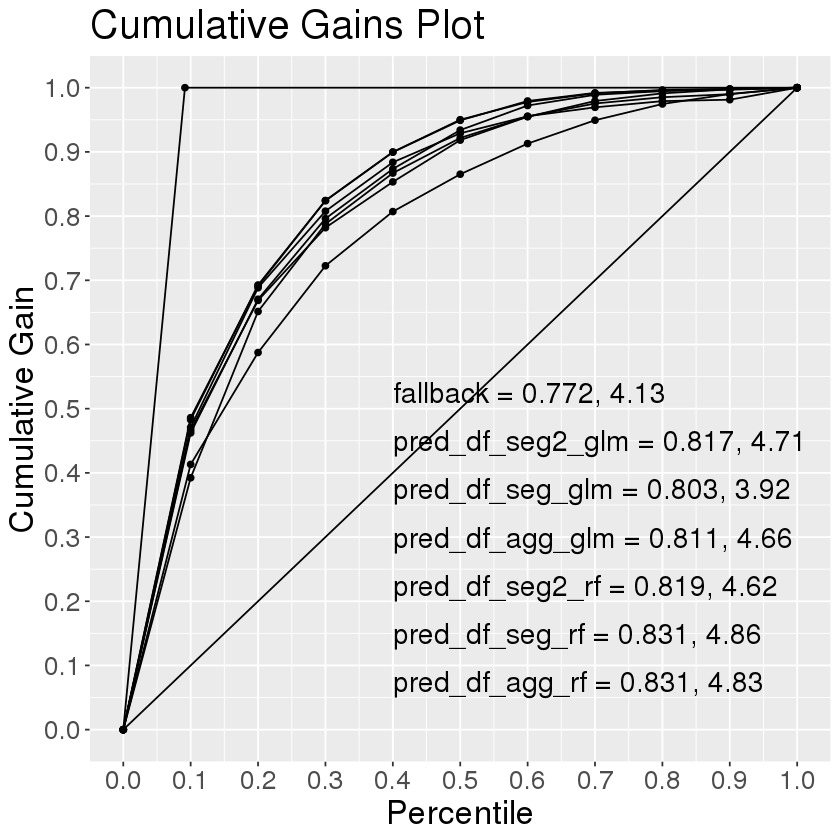

In [86]:
plot_multigains(            lift_df_list=lift_list,
                             auc_list = auc_list,
                             prop_positive = 0.09149351) 

# Now with... using fallback for a subset of tld-resellers

In [88]:
names(expiry_test_df_1)

[1] "renewal_type"         "renewed_count"        "expiry_date"         
 [4] "domain_id"            "domain"               "creation_date"       
 [7] "status"               "tld"                  "registrar"           
[10] "reseller"             "reseller_country"     "region"              
[13] "reg_period"           "registrant_country"   "renewal_status"      
[16] "renew_mbg"            "renew_type"           "autorenew_type"      
[19] "renew_date"           "renew_registrar"      "renew_reseller"      
[22] "reg_revenue"          "reg_arpt"             "renew_period"        
[25] "renew_domain_revenue" "renew_arpt"           "reg_arpt_org"        
[28] "tld_registrar_index"  "sld"                  "sld_type"            
[31] "sld_length"           "sld_type2"            "day_domains"         
[34] "log_reg_arpt"         "gibb_score"           "pattern"             
[37] "cluster"              "pattern_score"        "pattern_domain_count"

In [102]:
# select those with 1 domain renewing
tld_resellers_4fallback <- expiry_test_df_1 %>%
  group_by(tld_registrar_index) %>%
  count() %>%
  filter(n==1) %>%
  pull(tld_registrar_index)

length(tld_resellers_4fallback)
head(tld_resellers_4fallback)

[1] 258

[1] "funcheck domain"     "funcrazy domains"    "funeasydns"         
[4] "funhostgator brazil" "funhosting concepts" "funhostpoint"

In [104]:
`%notin%` <- Negate(`%in%`)

test_predictions_fallback_df_2 <- test_predictions_fallback_df_2 %>% 
  mutate(pred_df_seg2_glm_fb = 
           renewal_rate * (tld_registrar_index %in% c(tld_resellers_4fallback)) + 
           pred_df_seg2_glm * (tld_registrar_index %notin% c(tld_resellers_4fallback)),
        pred_df_seg_glm_fb = 
           renewal_rate * (tld_registrar_index %in% c(tld_resellers_4fallback)) + 
           pred_df_seg_glm * (tld_registrar_index %notin% c(tld_resellers_4fallback)),
        pred_df_agg_glm_fb = 
           renewal_rate * (tld_registrar_index %in% c(tld_resellers_4fallback)) + 
           pred_df_agg_glm * (tld_registrar_index %notin% c(tld_resellers_4fallback)),
        pred_df_seg2_rf_fb = 
           renewal_rate * (tld_registrar_index %in% c(tld_resellers_4fallback)) + 
           pred_df_seg2_rf * (tld_registrar_index %notin% c(tld_resellers_4fallback)),
        pred_df_seg_rf_fb = 
           renewal_rate * (tld_registrar_index %in% c(tld_resellers_4fallback)) + 
           pred_df_seg_rf * (tld_registrar_index %notin% c(tld_resellers_4fallback)),
        pred_df_agg_rf_fb = 
           renewal_rate * (tld_registrar_index %in% c(tld_resellers_4fallback)) + 
           pred_df_agg_rf * (tld_registrar_index %notin% c(tld_resellers_4fallback)),
        
        )


In [101]:
expiry_test_df_1 %>%
  group_by(tld_registrar_index) %>%
  count() %>%
  filter(tld_registrar_index=='funcrazy domains') 

tld_registrar_index,n
<chr>,<int>
funcrazy domains,1


In [105]:
head(test_predictions_fallback_df_2)

,tld,reseller_geo,reg_arpt_slab,reseller,reseller_country,domain_id,renewal_type,renewed_count,expiry_date,domain,creation_date,status,registrar,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,⋯,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,pred_df_seg2_glm,pred_df_seg_glm,pred_df_agg_glm,pred_df_seg2_rf,pred_df_seg_rf,pred_df_agg_rf,renewal_rate,pred_df_seg2_glm_fb,pred_df_seg_glm_fb,pred_df_agg_glm_fb,pred_df_seg2_rf_fb,pred_df_seg_rf_fb,pred_df_agg_rf_fb
,<fct>,<fct>,<fct>,<chr>,<chr>,<int>,<chr>,<int>,<date>,<chr>,<date>,<chr>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,⋯,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,fun,Australia & New Zealand,"(3,5]",instra corporation,Australia,104893671,FirstTime,1,2020-05-25,laur.fun,2019-05-25,Active,instra corporation,Non China,1,NA,Not Renewd,0,auto-renewal,NA,2020-05-25,Instra Corporation,Instra Corporation,4,4,⋯,funinstra corporation,laur,l,4,4l,1,1.386294,5.48,laur,1,1,1,NA,0.000,0.151,0.00000,0.1851779,0.3718108,0.2500000,NA,0.000,0.151,0.00000,0.1851779,0.3718108
2,fun,Australia & New Zealand,"(3,5]",instra corporation,Australia,99540944,FirstTime,1,2020-04-10,oferty.fun,2019-04-10,Active,instra corporation,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-04-10,Instra Corporation,Instra Corporation,4,4,⋯,funinstra corporation,oferty,l,6,6l,1,1.386294,6.03,oferty,1,1,1,NA,0.000,0.146,0.00000,0.2157494,0.3943426,0.2500000,NA,0.000,0.146,0.00000,0.2157494,0.3943426
3,fun,Australia & New Zealand,"(5,10]",crazy domains,Australia,62376247,FirstTime,1,2020-03-07,tennisladder.fun,2018-03-07,Active,crazy domains,Non China,2,NA,Not Renewd,0,auto-renewal,unrealized,2020-03-07,Crazy Domains,Crazy Domains,18,9,⋯,funcrazy domains,tennisladder,l,12,12l,1,2.197225,4.85,tennisladder,1,1,1,1.0000000,0.400,0.334,0.42460,0.5788189,0.6221085,0.5000000,0.5000000,0.500,0.500,0.50000,0.5000000,0.5000000
4,fun,Australia & New Zealand,"(10,15]",ventraip,Australia,95252714,FirstTime,1,2020-03-03,letterific.fun,2019-03-03,Active,synergy wholesale,Non China,1,NA,Renewed,0,renewal,NA,2020-02-19,SYNERGY WHOLESALE,VentraIP,15,15,⋯,funventraip,letterific,l,10,10l,1,2.708050,5.97,letterific,1,1,1,NA,NA,NA,NA,NA,NA,0.3333333,NA,NA,NA,NA,NA,NA
5,fun,Canada,"(5,10]",shopify,Canada,98381634,FirstTime,1,2020-03-29,abtractstore.fun,2019-03-29,Active,tucows,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-03-29,Tucows,Shopify,8,8,⋯,funshopify,abtractstore,l,12,12l,1,2.079442,5.45,abtractstore,1,1,1,0.2172645,0.277,0.067,0.28220,0.2351863,0.2068615,0.5263158,0.2172645,0.277,0.067,0.28220,0.2351863,0.2068615
6,fun,Canada,"(5,10]",hover,Canada,104937931,FirstTime,1,2020-05-26,futurefantasy.fun,2019-05-26,Active,tucows,Non China,1,NA,Renewed,0,renewal,NA,2020-05-25,Tucows,Hover,8,8,⋯,funhover,futurefantasy,l,13,13l,1,2.079442,5.61,futurefantasy,1,1,1,0.6261119,0.624,0.267,0.59825,0.5677353,0.4933172,0.5263158,0.6261119,0.624,0.267,0.59825,0.5677353,0.4933172


In [106]:
lift_list_2 <- list()
auc_list_2 <- list()

fallback_lift <- chart_lift(pred_df=test_predictions_fallback_df_2,
                        dep_var = "renewal_status",
                        pred_var = "renewal_rate") 

lift_list_2[["fallback"]] <- fallback_lift
auc_list_2[["fallback"]] <- calc_auc(lift_df=fallback_lift)

models <- c('pred_df_seg2_glm_fb',	'pred_df_seg_glm_fb',	'pred_df_agg_glm_fb',	'pred_df_seg2_rf_fb',	
            'pred_df_seg_rf_fb',	'pred_df_agg_rf_fb')


for (model in models){
    model_lift <- chart_lift(pred_df=test_predictions_fallback_df_2,
                        dep_var = "renewal_status",
                        pred_var = model) 
    
    fallback_lift <- merge(fallback_lift, model_lift, by=c("P"),all= TRUE, 
                           suffixes = c("",
                                        paste("_",gsub("pred_df_", "", model)) ))
    
    lift_list_2[[model]] <- model_lift
    auc_list_2[[model]] <- calc_auc(lift_df=model_lift)
}

lift_df_2 <- fallback_lift

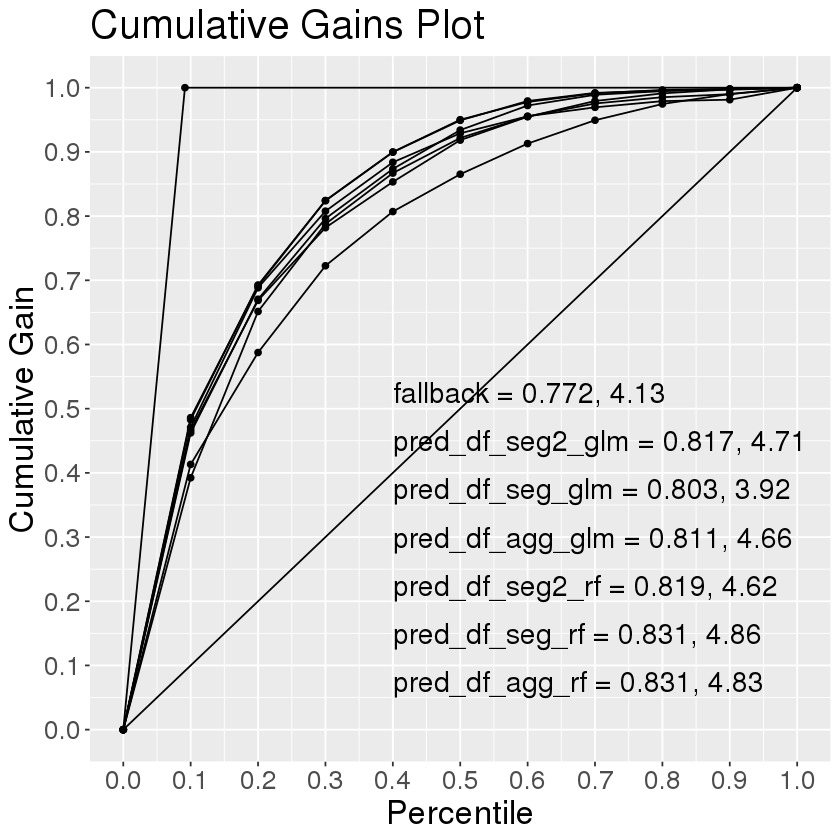

In [107]:
plot_multigains(            lift_df_list=lift_list,
                             auc_list = auc_list,
                             prop_positive = 0.09149351) 

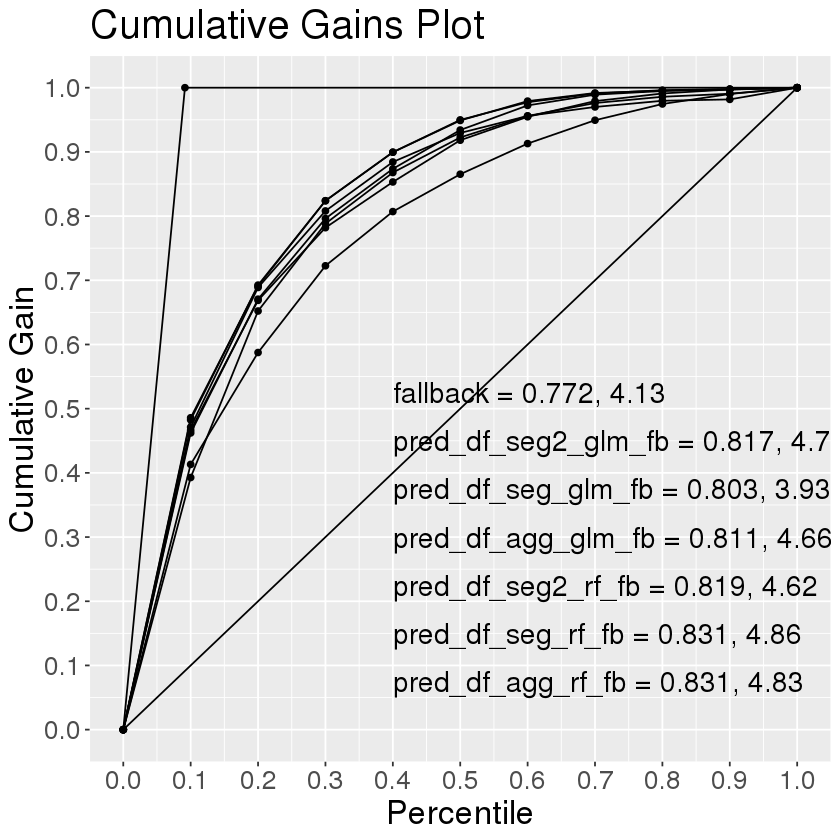

In [108]:
plot_multigains(            lift_df_list=lift_list_2,
                             auc_list = auc_list_2,
                             prop_positive = 0.09149351) 